### Investigating GPT-3.5's internal semantic network.

In [1]:
## You can use this notebook to explore the network and the data.

### To create the word_paths.json file, run dictionary_search.py.
### To create the word_graph.html file, run semantic_network.py.

### If you want to explore the full network, you can download the word_graph.html file and open it in your browser,
### but 10K nodes is a lot to load, so it might take a while to load. Physics is off by default to ensure quick loading.

In [2]:
# import libraries
import json
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
from tqdm import tqdm
import re
import pronouncing
nltk.download('cmudict')


[nltk_data] Downloading package cmudict to
[nltk_data]     /Users/samuelshapley/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


True

In [3]:
# Firstly, let's load the word paths from the json file and create the graph.
with open("word_paths.json", 'r') as f:
    word_paths = json.load(f)

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for word, paths in word_paths.items():
    for path_word in paths:
        G.add_edge(word, path_word)

In [4]:
# Now let's get some statistics about the network.
import matplotlib.pyplot as plt

# Number of nodes
print("Number of nodes: ", G.number_of_nodes())

# Number of edges
print("Number of edges: ", G.number_of_edges())

# Average degree
print("Average degree: ", sum([G.degree(n) for n in G.nodes()])/G.number_of_nodes())

# Average clustering coefficient
print("Average clustering coefficient: ", nx.average_clustering(G))

# Density
print("Density: ", nx.density(G))

# Degree distribution
# import collections
# degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
# degreeCount = collections.Counter(degree_sequence)
# deg, cnt = zip(*degreeCount.items())
# plt.figure(figsize=(20, 10))
# plt.bar(deg, cnt, width=0.80, color='b')
# plt.title("Degree Histogram")
# plt.ylabel("Count")
# plt.xlabel("Degree")
# plt.show()


Number of nodes:  13999
Number of edges:  29975
Average degree:  4.282448746339024
Average clustering coefficient:  0.05552245760124998
Density:  0.00015296645043359853


## How does GPT view words as similar?

#### Due to the nature of the LLM generation, we can mostly group the word paths into 3 distinct categories. 
<ol>
<li>Anagrams and Partial Anagrams/Continuations</li>
<li>Rhyming words</li>
<li>Semantic similarity</li>
</ol>

We can investigate each of these groups in turn.

In [5]:
# Anagrams

## A perfect anagram is one where no letters are added or removed, and the letters are just rearranged.

def get_anagram_type(word, anagram):
    """
    This function determines the type of anagram for a pair of words.
    
    Args:
        word (str): The original word.
        anagram (str): The anagram of the original word.
        
    Returns:
        str: The type of anagram. This will be one of the following values:
             'REVERSAL' if the anagram is the original word reversed,
             'SINGLE_CONSECUTIVE_SWAP' if the anagram is the result of swapping two consecutive letters in the original word,
             'SINGLE_SWAP' if the anagram is the result of swapping two non-consecutive letters in the original word,
             'CYCLIC' if the anagram is a cyclic permutation of the original word,
             'COMPLEX ANAGRAM' if the anagram does not fit any of the above categories.
    """
    # Check for reversal
    if word == anagram[::-1]:
        return "REVERSAL"
    
    # Check for single consecutive swap
    elif any(word[i:i+2][::-1] == anagram[i:i+2] for i in range(len(word)-1)):
        return "SINGLE_CONSECUTIVE_SWAP"
    
    # Check for single non-consecutive swap
    elif any(word[i] == anagram[j] and word[j] == anagram[i] for i in range(len(word)) for j in range(i+1, len(word))):
        return "SINGLE_SWAP"
    
    # Check for cyclic permutation
    elif any(word[i:] + word[:i] == anagram for i in range(len(word))):
        return "CYCLIC"
    
    # If none of the above conditions are met, it's a complex anagram
    else:
        return "COMPLEX ANAGRAM"


anagram_count = 0
anagram_data = []

for word, paths in word_paths.items():
    for idx, path_word in enumerate(paths):
        if sorted(word) == sorted(path_word):
            anagram_type = get_anagram_type(word, path_word)
            anagram_count += 1
            anagram_data.append({'Original Word': word, 'Anagram': path_word, 'Position': idx+1, 'Word Length': len(word), 'Type': anagram_type})

df = pd.DataFrame(anagram_data)

print("Number of perfect anagrams: ", anagram_count)
print(df)

## Show the positions and counts of perfect anagrams as a dictionary
anagram_positions = dict(df['Position'].value_counts())
print("Positions: ", anagram_positions)

## Show the dictionary of anagram types and counts
anagram_types = dict(df['Type'].value_counts())
print("Anagram Types: ", anagram_types)

## Show the dictionary of word lengths and counts
word_lengths = dict(df['Word Length'].value_counts())
print("Word Lengths: ", word_lengths)

#### We see that there are 114 perfect anagrams out of a total of 10,000 words.
#### The most common position for a perfect anagram is 1, which means that the anagram is the first result in the word path.

### Unsurprisingly, the longest perfect anagram is conservation and conversation, both of which have 12 letters. 
## Even humans make mistakes with these two words!
print(df[df['Word Length'] == df['Word Length'].max()])

Number of perfect anagrams:  114
    Original Word Anagram  Position  Word Length                     Type
0              on      no         3            2                 REVERSAL
1            from    form         1            4  SINGLE_CONSECUTIVE_SWAP
2             own     now         2            3                   CYCLIC
3             per     rep         3            3                 REVERSAL
4             god     dog         1            3                 REVERSAL
..            ...     ...       ...          ...                      ...
109           rot     tor         1            3                 REVERSAL
110          juet    jute         2            4  SINGLE_CONSECUTIVE_SWAP
111          arcs    cars         2            4          COMPLEX ANAGRAM
112            mg      gm         2            2                 REVERSAL
113         diocs   socid         2            5              SINGLE_SWAP

[114 rows x 5 columns]
Positions:  {1: 47, 3: 40, 2: 27}
Anagram Types:  {'REV

Number of words with continuations:  5386
Positions:  {3: 1813, 2: 1808, 1: 1765}
Letters Before Change:  {1: 1603, 2: 952, 3: 707, 4: 609, 5: 543, 6: 383, 7: 290, 8: 157, 9: 77, 10: 39, 11: 17, 12: 7, 13: 2}
Number of pluralised changes:  280
Number of singularised changes:  0
     Original Word     Path Word  Letters Before Change  Match Position  \
0               to           the                      1               2   
1               is            it                      1               1   
2              for          four                      2               2   
3               it            is                      1               1   
4              his           her                      1               3   
...            ...           ...                    ...             ...   
5381        dorset           dog                      2               1   
5382         diocs         discs                      2               3   
5383   restorative       restore              

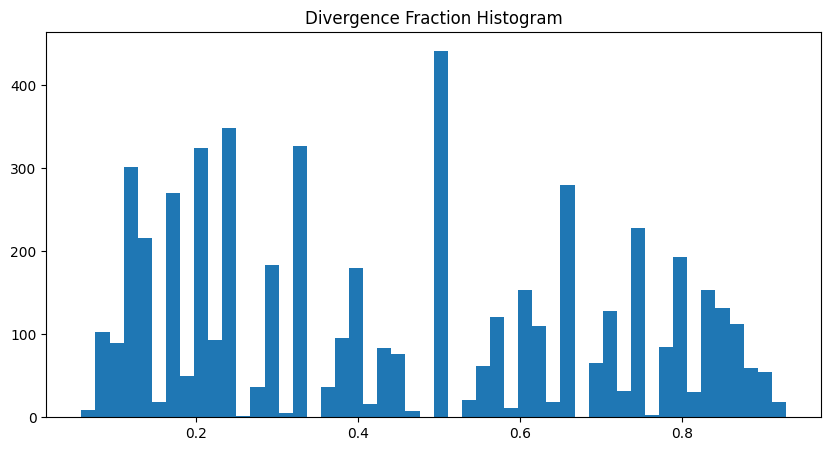

In [6]:
### Another common occurence is when the LLM begins to generate the word, but due to the restriction, changes to a different word.
### The following script looks at these occurences, and the number of letters that were generated before the change.
### If we normalise this by the length of the original word, we can define a value called the "divergence fraction".

def get_common_prefix_length(word1, word2):
    """
    This function returns the length of the common prefix between two words.
    
    Args:
        word1 (str): The first word.
        word2 (str): The second word.
        
    Returns:
        int: The length of the common prefix.
    """
    i = 0
    while i < len(word1) and i < len(word2) and word1[i] == word2[i]:
        i += 1
    return i

continuation_data = []

for word, paths in word_paths.items():
    for idx, path_word in enumerate(paths):
        common_prefix_length = get_common_prefix_length(word, path_word)
        # Ensure the path word is not a perfect match with the original word
        if common_prefix_length > 0 and common_prefix_length < len(word):
            continuation_data.append({
                'Original Word': word, 
                'Path Word': path_word, 
                'Letters Before Change': common_prefix_length,
                'Match Position': idx+1
            })

df_continuations = pd.DataFrame(continuation_data)

# Add the Divergence Fraction column
df_continuations['Divergence Fraction'] = df_continuations['Letters Before Change'] / df_continuations['Original Word'].str.len()

# How many words are in this category?
print("Number of words with continuations: ", len(df_continuations))

## Show the positions and counts of continuations as a dictionary
continuation_positions = dict(df_continuations['Match Position'].value_counts())
print("Positions: ", continuation_positions)

## Show the dictionary of letters before change and counts
letters_before_change = dict(df_continuations['Letters Before Change'].value_counts())
print("Letters Before Change: ", letters_before_change)

# plot the divergence fraction
plt.figure(figsize=(10, 5))
plt.hist(df_continuations['Divergence Fraction'], bins=50)
plt.title("Divergence Fraction Histogram")




### How many words have just been pluralised/singularised?


# Function to check if a word has been singularized or pluralized
def check_plural_singular(word1, word2):
    """
    This function checks whether one word is a plural/singular form of another.
    
    Args:
        word1 (str): The first word.
        word2 (str): The second word.
        
    Returns:
        str: 'Pluralised', 'Singularised' or 'None'.
    """
    if word1 == word2 + 's':
        return 'Pluralised'
    elif word2 == word1 + 's':
        return 'Singularised'
    else:
        return 'None'

# Add the Plural/Singular column
df_continuations['Plural/Singular'] = df_continuations.apply(lambda row: check_plural_singular(row['Original Word'], row['Path Word']), axis=1)

# Count the number of plural/singular changes
plural_count = df_continuations[df_continuations['Plural/Singular'] == 'Pluralised'].shape[0]
singular_count = df_continuations[df_continuations['Plural/Singular'] == 'Singularised'].shape[0]

print("Number of pluralised changes: ", plural_count)
print("Number of singularised changes: ", singular_count)

print(df_continuations)


### We could view words with higher divergence fractions as being more robust somehow.

df_continuations[df_continuations['Plural/Singular'] == 'None'].sort_values(by='Divergence Fraction', ascending=False).head(20)


### How many distinct original words with continuations are there, check Original Word column

print("Number of distinct original words with continuations: ", len(df_continuations['Original Word'].unique()))

### How many of these words appear only once, twice or three times?

original_word_counts = dict(df_continuations['Original Word'].value_counts())
print("Number of original words with continuations that appear only once: ", len([k for k, v in original_word_counts.items() if v == 1]))
print("Number of original words with continuations that appear only twice: ", len([k for k, v in original_word_counts.items() if v == 2]))
print("Number of original words with continuations that appear three times: ", len([k for k, v in original_word_counts.items() if v == 3]))


In [7]:
## aditional things to search
### other types of anagrams
### most common words ie biggest nodes

## numbers + the war thing
### build a genral streamlit app that allows peopel to search for words and see the paths, generate them live

In [8]:
import nltk
import pronouncing
import pandas as pd
from tqdm import tqdm

# Load the CMU Pronouncing Dictionary
cmu_dict = nltk.corpus.cmudict.dict()

# Function to get the phonemes of a word
def get_phonemes(word):
    """
    This function returns the phonemes of a word.
    
    Args:
        word (str): The word.
        
    Returns:
        list: The phonemes of the word.
    """
    return cmu_dict[word][0]

# Function to get the rhyming words of a word
def get_rhyming_words(word, library='cmu'):
    """
    This function returns the rhyming words of a word.
    
    Args:
        word (str): The word.
        library (str): The library to use. 'cmu' for CMU Pronouncing Dictionary, 'pronouncing' for pronouncing library.
        
    Returns:
        list: The rhyming words of the word.
    """
    if library == 'cmu':
        phonemes = get_phonemes(word)
        rhyming_words = []
        for word, phonemes_list in cmu_dict.items():
            if phonemes_list[0][-2:] == phonemes[-2:]:
                rhyming_words.append(word)
    elif library == 'pronouncing':
        rhyming_words = pronouncing.rhymes(word)
    else:
        raise ValueError(f"Invalid library name: {library}")
    
    return rhyming_words

# Load word_paths.json, and for each word, find the rhyming words.
rhyming_pairs = []
unrhymable_words = []
for word, paths in tqdm(list(word_paths.items())):
    for idx, path_word in enumerate(paths):
        try:
            if path_word in get_rhyming_words(word, library='pronouncing'): # change library to 'cmu' for CMU Pronouncing Dictionary
                rhyming_pairs.append((word, path_word, idx+1))
        except:
            unrhymable_words.append(word)
            continue

rhyming_df = pd.DataFrame(rhyming_pairs, columns=['Original Word', 'Rhyming Word', 'Matching Position'])


100%|██████████| 10000/10000 [00:00<00:00, 27961.84it/s]


In [9]:
rhyming_df

### apparently 6k are rhyming words (but if we use the pronouncing library, it's 2.8K)

,Original Word,Rhyming Word,Matching Position
0,to,too,1
1,to,do,3
2,that,cat,2
3,he,she,2
4,for,four,2
...,...,...,...
2836,hips,ships,2
2837,archaeological,logical,3
2838,retreated,defeated,2
2839,decreased,ceased,2


In [ ]:
### Check thesaurus words. We can use the NLTK WordNet corpus to find synonyms and antonyms of words.

In [ ]:
### Manually label semantic similarity of words possible.

In [24]:
### Write a script which can perform all of these checks and analyse them to produce a list of words and all theyve been altered.
### Words can be in multiple categories, so we can have a column for each category and a 1 if the word is in that category and a 0 if not.
### We can then use this to train a model to predict the category of a word *maybe not necessary*

## Main thing would be to see how many words are in each category and how many words are in multiple categories, plot this as some sort of graph
## to show clusters of words in different categories.

### Currently the categories are:

# 1. Anagrams
# 2. Continuations (subset -s, -ed, -ing etc)
# 3. Inverse Continuations (i.e mall -> ball, fall, call)
# 3. Rhyming Words
### Rhyming words are words that have the same or similar ending sound. For example, "cat" and "hat." This is a phonemic similarity.
# 4. Synonyms
### Synonyms are words that have the same or similar meanings. For example, "happy" and "glad."
# 5. Antonyms
#### Antonyms are words that have opposite meanings. For example, "hot" and "cold."
# 6. Homophones
#### Homophones are words that sound the same but may have different spellings and meanings. For example, "write" and "right."
# 7. Homographs
#### Homographs are words that are spelled the same but have different meanings. For example, "lead" meaning to guide someone, and "lead" meaning a metal.
### SO this one doesn't make sense as we are only looking at words that have been changed.
# Letter match in any position??

### Orthographic similarity
#### Orthographic similarity is when words have the same or similar spellings visually. 

### syncactic similarity
### i.e do nouns become verbs, verbs become nouns, what is the chain of words that are created
# 
#  
### check for subwords, i.e. words that are contained within other words

### Check also if they are the same length